# Generating human faces with Adversarial Networks
[![img](https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg)](http://payload.cargocollective.com/1/0/17293/393670/HumanTaxidermy01.jpg)

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .


## Import modules

In [11]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
from utils import reset_tf_session
from utils import download_file
from utils import ModelSaveCallback

## Load dataset

In [3]:
url1 = 'http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt'
filepath1 = '/Users/molinaro/.keras/datasets/lfw_attributes.txt'

url2 = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
filepath2 = '/Users/molinaro/.keras/datasets/lfw-deepfunneled.tgz'

url3 = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
filepath3 = '/Users/molinaro/.keras/datasets/lfw.tgz'

download_file(url1, filepath1)
download_file(url2, filepath2)
download_file(url3, filepath3)

In [4]:
import tarfile
import tqdm
import cv2
import os

ATTRS_NAME = filepath1 
IMAGES_NAME = filepath2  
RAW_IMAGES_NAME = filepath3 

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [8]:
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

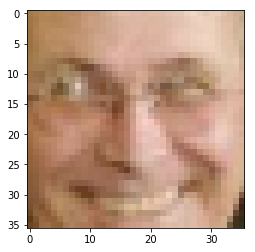

In [10]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

## Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning workflow: 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent 


The only problem is: how can we tell well-generated faces from bad? 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noise for inspiration and tries to generate a face sample. 
  * Let's call it __G__(z), where z is a gaussian noise.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call it __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [12]:
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [13]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))

In [14]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

In [15]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 640)               164480    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 64)        16064     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 64)        102464    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 34, 34, 32)        18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 36, 36, 32)        9248      
__________

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [16]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

#<build discriminator body>
discriminator.add(L.Conv2D(16,kernel_size=(3, 3),padding='same', activation='elu'))
discriminator.add(L.Conv2D(32,kernel_size=(3, 3),padding='same', activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))
discriminator.add(L.Conv2D(32,kernel_size=(3, 3),padding='same', activation='elu'))
discriminator.add(L.Conv2D(64,kernel_size=(3, 3),padding='same', activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))
discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

In [17]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 36, 36, 16)        448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
__________

## Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [18]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data) #<log P(real | gen(noise))

In [19]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [21]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_real[:,0] + logp_gen[:,1]) #<generator loss>

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

In [22]:
s.run(tf.global_variables_initializer())

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [24]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

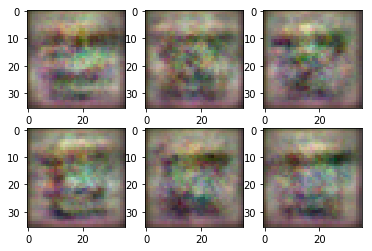

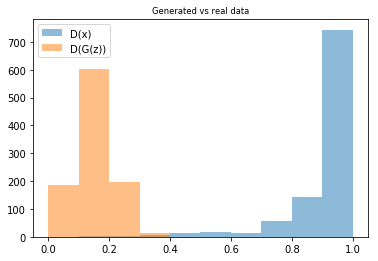

In [ ]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)

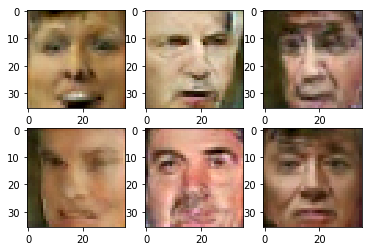

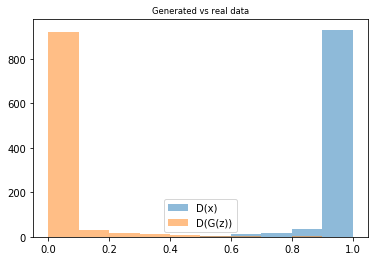

In [35]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)

In [ ]:
# save weights to file
discriminator.save_weights("weights_disc.h5")
generator.save_weights("weights_gen.h5")

In [41]:
discriminator.get_weights()

[array([[[[ 0.24833953, -0.21229987, -0.19031024,  0.07131442,  0.11562472,
            0.0874571 , -0.12890649,  0.26291427, -0.18888097,  0.20748791,
            0.08347314,  0.36223838, -0.01434522,  0.02089337,  0.49706987,
           -0.00755767],
          [-0.26253828, -0.11056862, -0.22745754, -0.14049114, -0.20938776,
           -0.11681414,  0.10245853,  0.18354324, -0.31943506,  0.34462276,
            0.02592787,  0.26130641, -0.12787154,  0.27159846, -0.35524282,
           -0.03812211],
          [ 0.07441659,  0.23280473,  0.19966333,  0.08009766, -0.09016638,
            0.23674472,  0.19642842, -0.29201624, -0.45645377, -0.01743406,
           -0.23682071, -0.06237164,  0.04524198, -0.26178968,  0.14929973,
            0.24483837]],
 
         [[ 0.10802415,  0.25072035,  0.06062468, -0.39135733,  0.23823923,
           -0.27700129,  0.22632349, -0.09549727, -0.05611525,  0.2404298 ,
            0.12609862, -0.04597272, -0.36380753,  0.34840152,  0.09270591,
          

In [42]:
generator.get_weights()

[array([[-0.08203362, -0.10768796,  0.03059214, ...,  0.03576101,
          0.13908957,  0.0030618 ],
        [-0.08605824, -0.08469321,  0.14500204, ...,  0.07394426,
          0.07606762, -0.01914516],
        [-0.03923305,  0.00629797,  0.0844754 , ..., -0.04940379,
          0.01716994,  0.11923593],
        ..., 
        [-0.08604459,  0.01847484,  0.14800821, ...,  0.01705767,
         -0.00461487,  0.03799651],
        [-0.03713251,  0.02119469, -0.03428466, ...,  0.05823991,
         -0.05099535, -0.06828974],
        [ 0.00047516, -0.06861146, -0.01875451, ..., -0.02469794,
         -0.03925698,  0.07307899]], dtype=float32),
 array([  6.65527701e-01,   5.56417227e-01,   9.46543217e-01,
          5.25169492e-01,   5.93719900e-01,   9.34413895e-02,
         -1.12633854e-01,  -7.48135149e-02,   4.12601769e-01,
          3.32093090e-01,   1.40048698e-01,   3.32301334e-02,
          4.52660173e-01,   4.40066867e-02,   1.85814530e-01,
          1.92756131e-02,  -4.41160619e-01,  -1

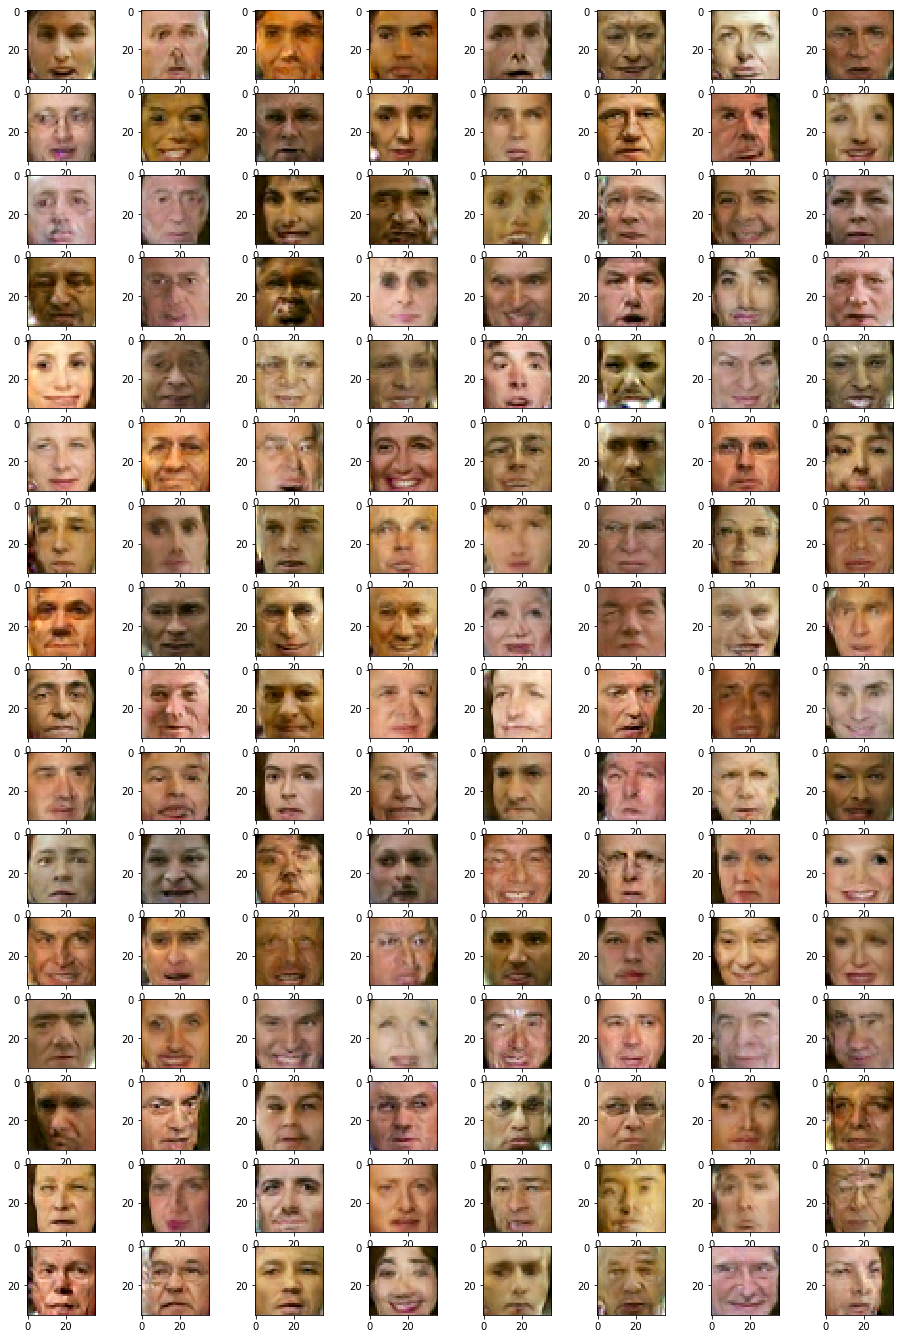

In [38]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)